In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16393377296099239041,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9984750400
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3132310414749105156
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:1d:00.0, compute capability: 6.1"]

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import SimpleITK as sitk 
from tqdm import tqdm
import numpy as np
%pylab inline

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans

from tensorflow.keras.utils import to_categorical,normalize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D,add,Input,Dropout,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda,PReLU,concatenate,Lambda
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Nadam
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.initializers as initializers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
for dirname, _, filenames in os.walk("C:/NewDataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_flair.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_seg.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_t1.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_t2.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_flair.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_seg.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_t1.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_t1ce.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_t2.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_flair.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_seg.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_t1.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_t2.nii
C:/NewDataset\BraTS20_Training_004\Br

In [4]:
path = "C:/NewDataset/"

In [5]:
def load_data(path):
    my_dir = sorted(os.listdir(path))
    data = []
    gt = []
    for p in tqdm(my_dir):
        data_list = sorted(os.listdir(path+p))
        
        img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
        flair = sitk.GetArrayFromImage(img_itk)
        flair = flair[30:120,30:222,30:222].reshape([-1,192,192])
        
        img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
        seg =  sitk.GetArrayFromImage(img_itk)
        seg = seg[30:120,30:222,30:222].reshape([-1,192,192])
        
        img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])
        t1 =  sitk.GetArrayFromImage(img_itk)
        t1 = t1[30:120,30:222,30:222].reshape([-1,192,192])
        

        img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
        t1ce =  sitk.GetArrayFromImage(img_itk)
        t1ce = t1ce[30:120,30:222,30:222].reshape([-1,192,192])

        img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
        t2 =  sitk.GetArrayFromImage(img_itk)
        
        t2 = t2[30:120,30:222,30:222].reshape([-1,192,192])

        data.append([flair,t1,t1ce,t2])
        gt.append(seg)
    data = np.asarray(data,dtype=np.float32)
    gt = np.asarray(gt,dtype=np.uint8)
    return data,gt

In [6]:
data,gt = load_data(path)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.92it/s]


In [7]:
data.shape

(100, 4, 90, 192, 192)

In [8]:
gt.shape

(100, 90, 192, 192)

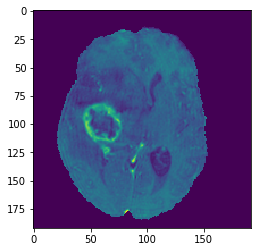

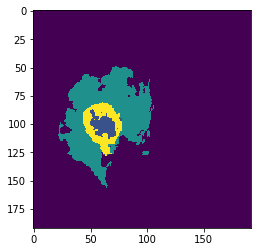

In [9]:
plt.imshow(data[0,2,42,:,:])
plt.show()
plt.imshow(gt[0,42,:,:])
plt.show()

In [10]:
data = np.transpose(data,(0,2,3,4,1))

In [11]:
data.shape,gt.shape,data.dtype,gt.dtype

((100, 90, 192, 192, 4), (100, 90, 192, 192), dtype('float32'), dtype('uint8'))

In [12]:
data = data.reshape([-1,192,192,4])
gt = gt.reshape([-1,192,192,1])

In [13]:
data.shape,gt.shape,data.dtype,gt.dtype

((9000, 192, 192, 4), (9000, 192, 192, 1), dtype('float32'), dtype('uint8'))

In [15]:
gt[np.where(gt==4)]=3

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(data, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42) 

In [17]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [18]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((5400, 192, 192, 4),
 (5400, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 1))

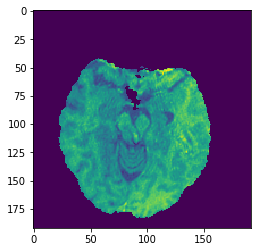

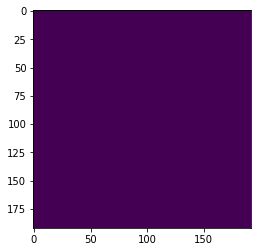

In [19]:
plt.imshow(X_train[0,:,:,1])
plt.show()
plt.imshow(Y_train[0,:,:,1])
plt.show()

In [20]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((5400, 192, 192, 4),
 (5400, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 4))

In [21]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# U_NET MODEL WITH_SOBEL_OPERATOR

In [22]:
wdata = np.zeros_like(data)

In [23]:
from skimage.segmentation import watershed
import cv2

def sobel(img):
    Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_sobelx = cv2.Sobel(img, cv2.CV_8U,1,0,ksize=3)
    img_sobely = cv2.Sobel(img, cv2.CV_8U,0,1,ksize=3)
    img_sobel = img_sobelx + img_sobely+img
    
    return img_sobel

(-0.5, 191.5, 191.5, -0.5)

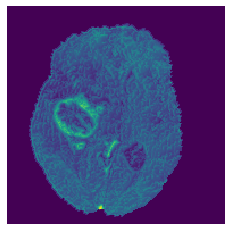

In [24]:
plt.imshow(sobel(data[40, :, :, 2]))
plt.axis("off")

In [25]:
for i in range(len(data)):
    for j in range(4):
        wdata[i,:,:,j] = sobel(data[i,:,:,j])

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(wdata, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [27]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [28]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((5400, 192, 192, 4),
 (5400, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 1))

In [29]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((5400, 192, 192, 4),
 (5400, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 4))

In [30]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [31]:
#encoder

inputs = Input(shape=(192,192,4),name='input')                                              

block0_conv1 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv1')(inputs)
block0_norm1 = BatchNormalization(name='block0_batch_norm1')(block0_conv1)
block0_conv2 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv2')(block0_norm1)
block0_norm2 = BatchNormalization(name='block0_batch_norm2')(block0_conv2)
block0_pool = MaxPooling2D(name='block0_pool')(block0_norm2)

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(block0_pool)
block1_norm1 = BatchNormalization(name='block1_batch_norm1')(block1_conv1)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_norm1)
block1_norm2 = BatchNormalization(name='block1_batch_norm2')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm2)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_norm1 = BatchNormalization(name='block2_batch_norm1')(block2_conv1)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_norm1)
block2_norm2 = BatchNormalization(name='block2_batch_norm2')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm2)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_norm1 = BatchNormalization(name='block3_batch_norm1')(block3_conv1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_norm1)
block3_norm2 = BatchNormalization(name='block3_batch_norm2')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm2)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_norm1 = BatchNormalization(name='block4_batch_norm1')(block4_conv1)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_norm1)
block4_norm2 = BatchNormalization(name='block4_batch_norm2')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm2)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)

#decoder
up_pool1 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = Add()([block4_norm1, block4_norm2, up_pool1])
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = Add()([block3_norm1, block3_norm2, up_pool2])
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = Add()([block2_norm1, block2_norm2 ,up_pool3])
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = Add()([block1_norm1, block1_norm1, up_pool4])
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

up_pool5 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool5')(decod_block4_conv1)
merged_block5 = Add()([block0_norm1, block0_norm2 ,up_pool5])
decod_block5_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block5_conv1')(merged_block5)

pre_output = Conv2D(32,1,padding = 'same',activation='relu',name='pre_output')(decod_block5_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model = Model(inputs = inputs, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 192, 192, 4) 0                                            
__________________________________________________________________________________________________
block0_conv1 (Conv2D)           (None, 192, 192, 32) 1184        input[0][0]                      
__________________________________________________________________________________________________
block0_batch_norm1 (BatchNormal (None, 192, 192, 32) 128         block0_conv1[0][0]               
__________________________________________________________________________________________________
block0_conv2 (Conv2D)           (None, 192, 192, 32) 9248        block0_batch_norm1[0][0]         
______________________________________________________________________________________________

In [33]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model.save_weights('weights.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = 'weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

In [34]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=16,epochs=30,callbacks=[checkpointer],shuffle=True)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

338/338 [==============================] - 46s 136ms/step - loss: 0.0064 - dice_coef: 0.9936 - accuracy: 0.9929 - val_loss: 0.0087 - val_dice_coef: 0.9913 - val_accuracy: 0.9906
Epoch 26/30
338/338 [==============================] - 46s 136ms/step - loss: 0.0063 - dice_coef: 0.9937 - accuracy: 0.9931 - val_loss: 0.0081 - val_dice_coef: 0.9919 - val_accuracy: 0.9912
Epoch 27/30
338/338 [==============================] - 46s 136ms/step - loss: 0.0061 - dice_coef: 0.9939 - accuracy: 0.9932 - val_loss: 0.0079 - val_dice_coef: 0.9921 - val_accuracy: 0.9914
Epoch 28/30
338/338 [==============================] - 44s 129ms/step - loss: 0.0060 - dice_coef: 0.9940 - accuracy: 0.9933 - val_loss: 0.0079 - val_dice_coef: 0.9921 - val_accuracy: 0.9914
Epoch 29/30
338/338 [==============================] - 43s 128ms/step - loss: 0.0057 - dice_coef: 0.9943 - accuracy: 0.9936 - val_loss: 0.0083 - val_dice_coef: 0.9917 - val_accuracy: 0.9910
Epoch 30/30
338/338 [==============================] - 43s 128

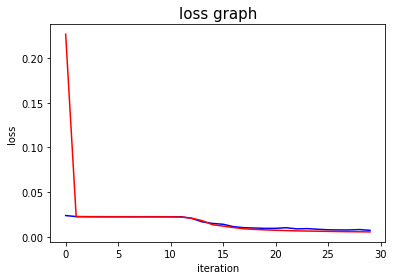

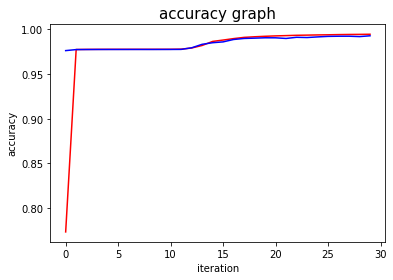

In [35]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.savefig("U_NET_SOBEL_history-loss.png")
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.savefig("U_NET_SOBEL_history-acc.png")
plt.show()

In [36]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [37]:
np.unique(Y_pre)

array([0, 1, 2, 3], dtype=int64)

In [38]:
Y_pre.shape

(1800, 192, 192)

In [39]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [40]:
Y_test.shape,X_test.shape

((1800, 192, 192, 1), (1800, 192, 192, 4))

X_test 10


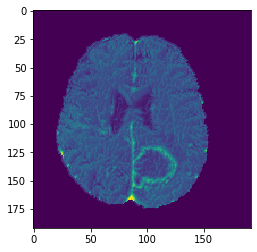

Predicted 10


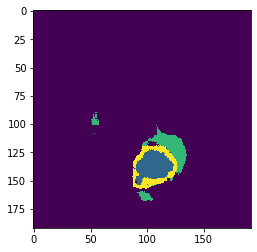

Actual 10


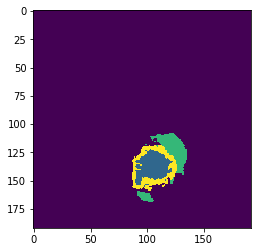

X_test 11


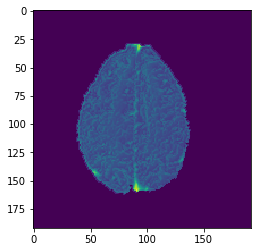

Predicted 11


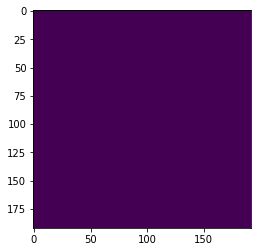

Actual 11


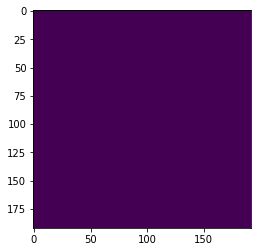

X_test 12


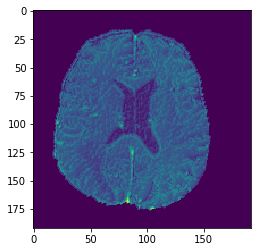

Predicted 12


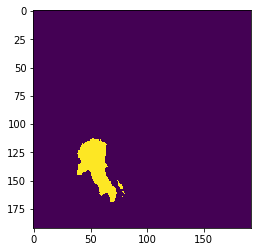

Actual 12


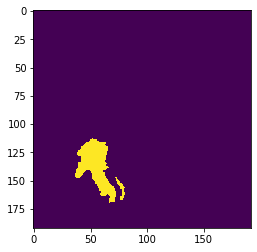

X_test 13


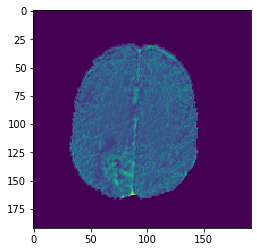

Predicted 13


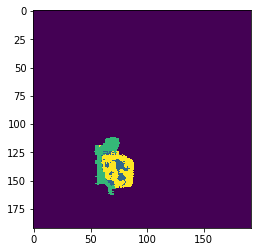

Actual 13


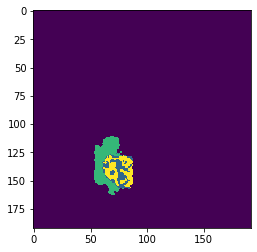

X_test 14


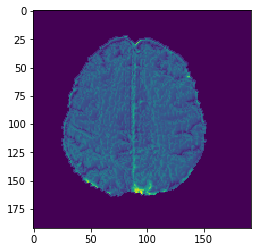

Predicted 14


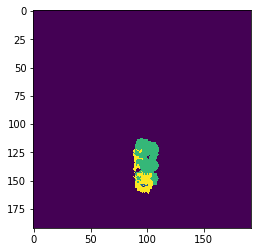

Actual 14


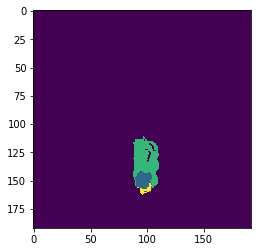

X_test 15


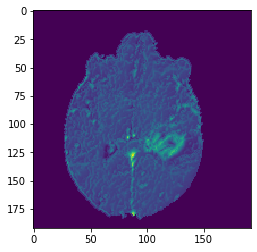

Predicted 15


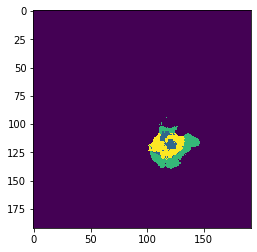

Actual 15


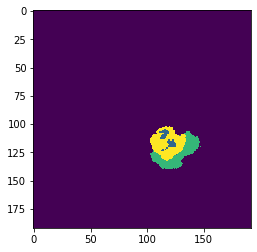

X_test 16


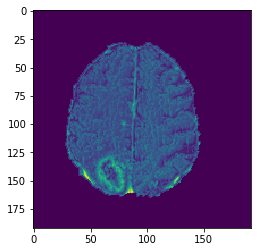

Predicted 16


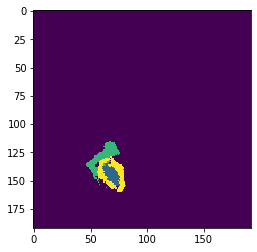

Actual 16


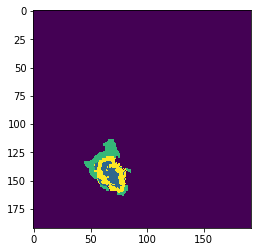

X_test 17


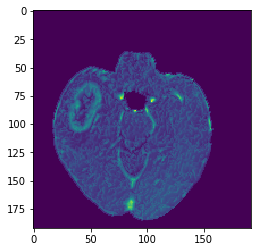

Predicted 17


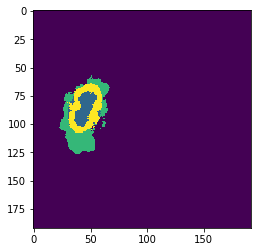

Actual 17


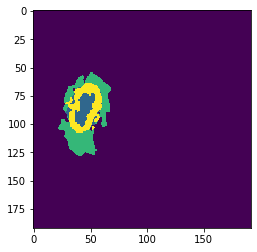

X_test 18


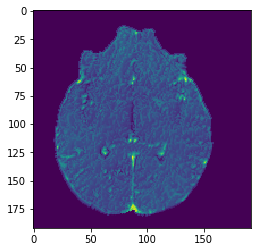

Predicted 18


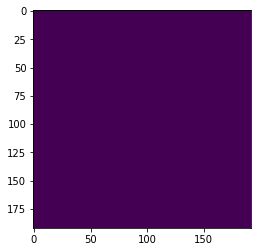

Actual 18


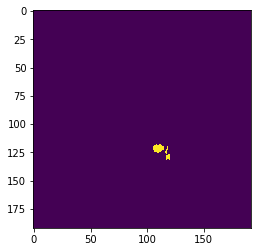

X_test 19


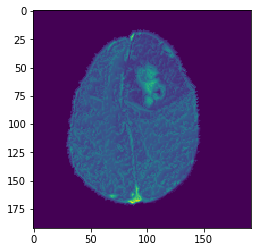

Predicted 19


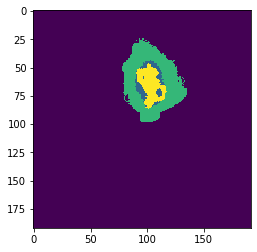

Actual 19


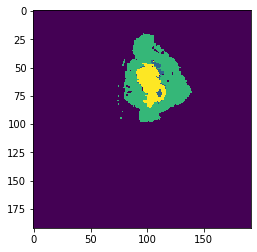

In [41]:
for i in range(10,20):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [42]:
Y_test_encod = to_categorical(Y_test)

In [43]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

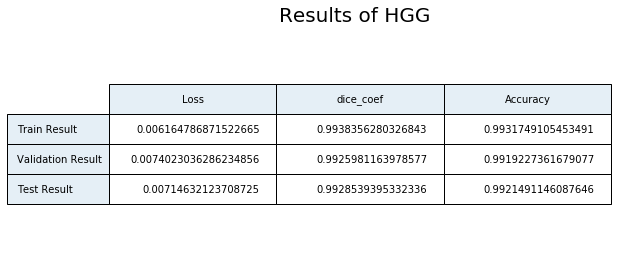

In [44]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.savefig("U_NET_SOBEL_result-table.png", bbox_inches="tight");

# END